# Machine Learning Magic: 
### Filling gaps in streamflow data sets using a Deep Learning Network

In [1]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))

#%matplotlib inline
%matplotlib notebook

import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import seaborn as sns
import os
import datetime
import keras 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import requests
import scipy
import tensorflow as tf

pd.set_option('display.max_rows', 1000)    
np.set_printoptions(suppress=True)


# import function from current working directory
from baseflow_separator import baseflow_separator

Using TensorFlow backend.


## Grab data

In [2]:
url = "https://raw.githubusercontent.com/cshuler/ASPA-UH_Integrated_Modeling_Framework/master/ASPA-UH_Stream_REPO/workspace/All_consolodated_Q_m3ps.csv"
save_to = os.path.join("..", 'Data', "All_consolodated_Q_m3ps.csv")

r = requests.get(url, allow_redirects=True)
open(save_to, 'wb').write(r.content)

16200025

## process Data


<IPython.core.display.Javascript object>


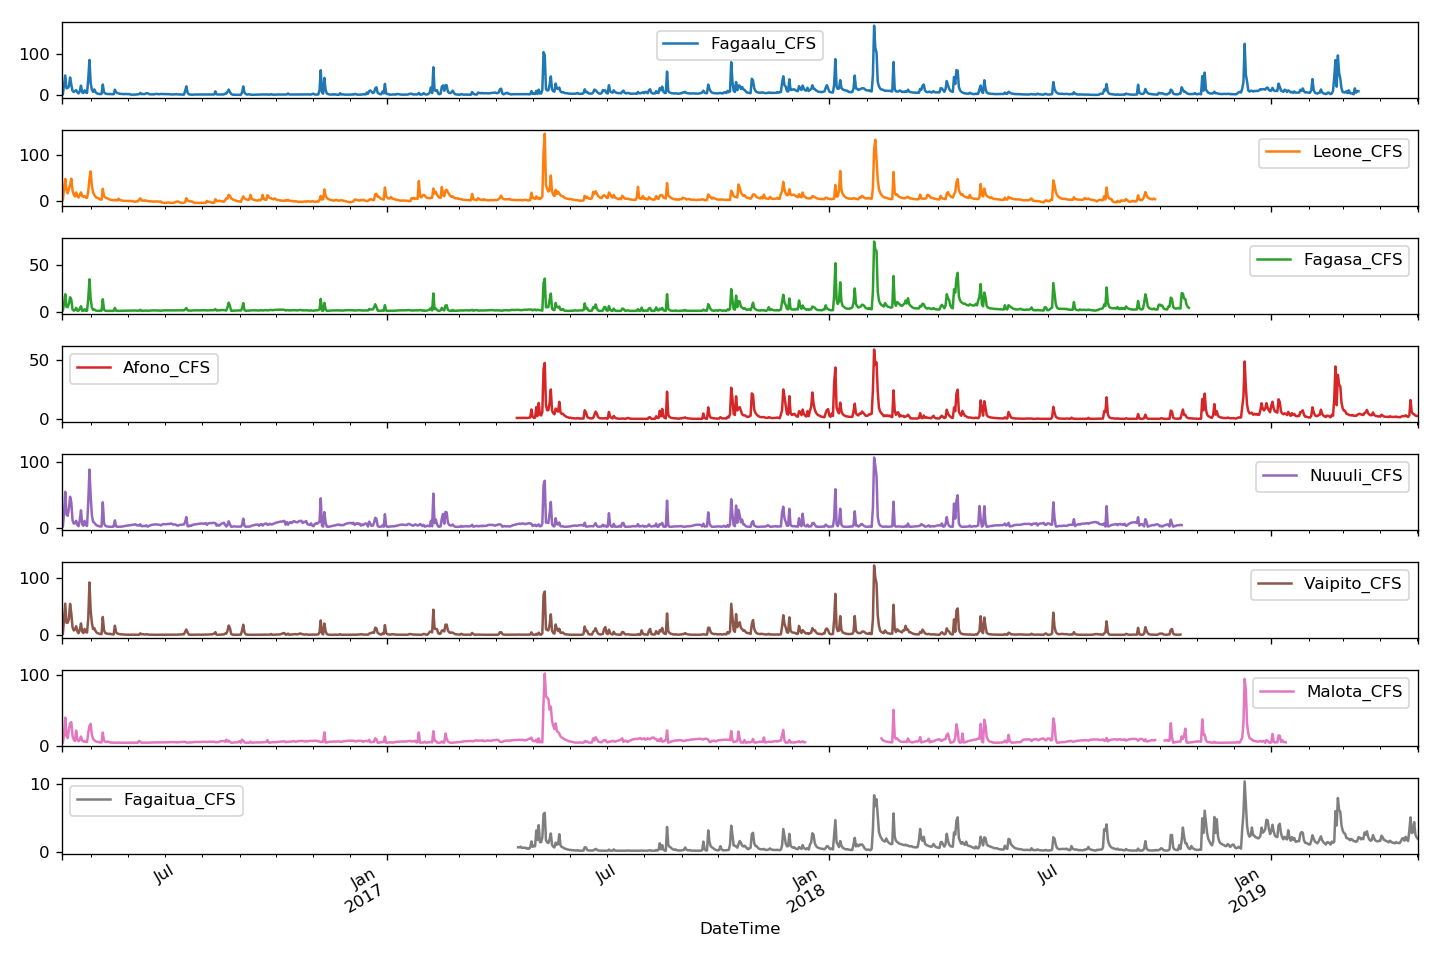

In [3]:
rawdata = pd.read_csv(save_to ,index_col=0,parse_dates=True)

dat = rawdata.resample('D').mean()     # subsample the 15 min data into daily values
dat = dat[10:]                          # this just to cut out some of the beginning days with no streamflows

data = pd.DataFrame(index=dat.index)
for column in dat:
    new_name = column.split("_")[0]+"_CFS"
    data[new_name] = dat[column]*35.314666212661 

data.plot(subplots=True, figsize=(12, 8))
plt.tight_layout()
plt.legend(loc='best')

# New stuff
Time to fill some real gaps with some fake data


<IPython.core.display.Javascript object>


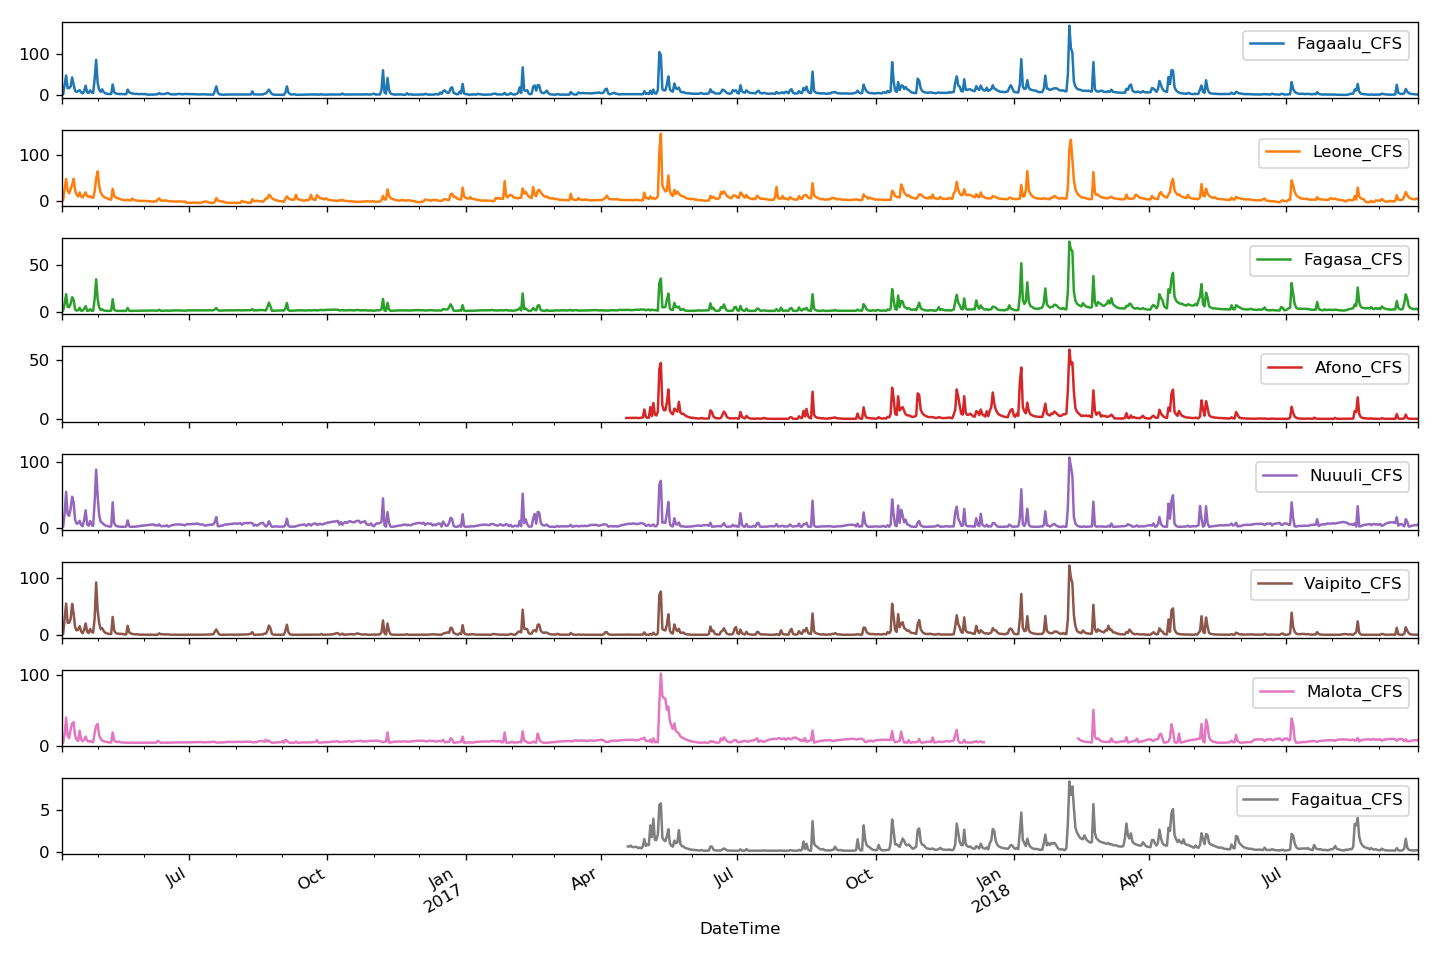

['Afono_CFS', 'Malota_CFS', 'Fagaitua_CFS']

In [4]:
# this block clips the dataset to not include any gaps at the end or beginning (except afono and fagaitua) which have begin gaps to fill

s1 = data.drop(['Afono_CFS', 'Fagaitua_CFS'], axis=1)   # first drop afono and fagaitua because they were started late and I want to fill their gap 
dateslist =[]
for i in s1:                 # take each column
    s2 = s1[i].dropna()      # remove the rows with no data
    s3 = (s2.index.min())    # find the first row with data
    dateslist.append(s3)     # stick all these first rows with data together
strt = max(dateslist)        # find the latest value in that list to ensure all rows for all series after this date will have data

dateslist =[]                # same thing but opposite to cut out data after the last of the shortest of the timeseries
for i in data:
    s2 = data[i].dropna()
    s3 = (s2.index.max())
    dateslist.append(s3)
eendd = min(dateslist)      # Now these are the dates of the dataset without strange beginning and end dates

# now use the appropriate start and end dates for the solid dataset
data_clipped_w_Mta = data.loc[strt:eendd]   # this is the data with no gaps on either end except for afono and fagaitua

#data_clipped = data_clipped_w_Mta.drop(['Malota_CFS'], axis=1) 
data_clipped=data_clipped_w_Mta   # delete later??? 

# plot results
data_clipped.plot(subplots=True, figsize=(12, 8))
plt.tight_layout()
plt.legend(loc='best')

# Here make a copy of the data to contain the filled data 
sneaky_data = data.copy()

# then iterate through each column to see which stations have any gaps needing some fill 
broken_sets = []
for i in data_clipped:
    if data_clipped[i].isnull().values.any():     #  If any of the rows have Na values for each column
        broken_sets.append(i)
broken_sets

<IPython.core.display.Javascript object>


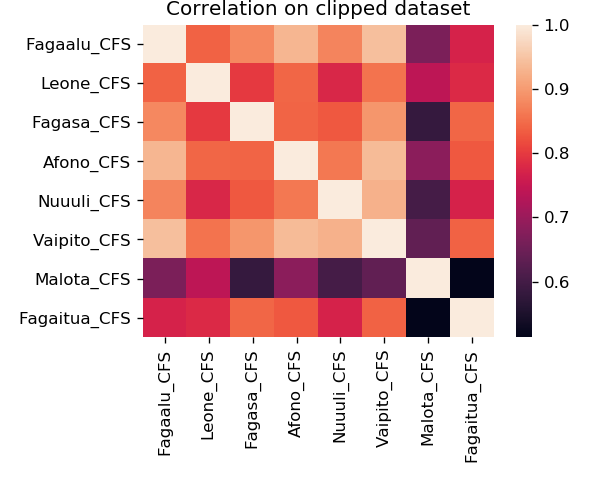

Text(0.5, 1.0, 'Correlation on clipped dataset')

In [22]:
fig, ax1= plt.subplots(figsize=(5, 4))
corr = data.corr()
sns.heatmap(corr,  xticklabels=data.columns.values, yticklabels=data.columns.values, ax=ax1)
plt.tight_layout()
ax1.set_title("Correlation on clipped dataset")

# Big loop over for each series with gaps to fill them

Some key syntax from https://stackoverflow.com/questions/41494444/pandas-find-longest-stretch-without-nan-values

gap filling for station Afono_CFS
Training with stations Index(['Leone_CFS', 'Nuuuli_CFS', 'Fagaalu_CFS', 'Vaipito_CFS'], dtype='object')


<IPython.core.display.Javascript object>


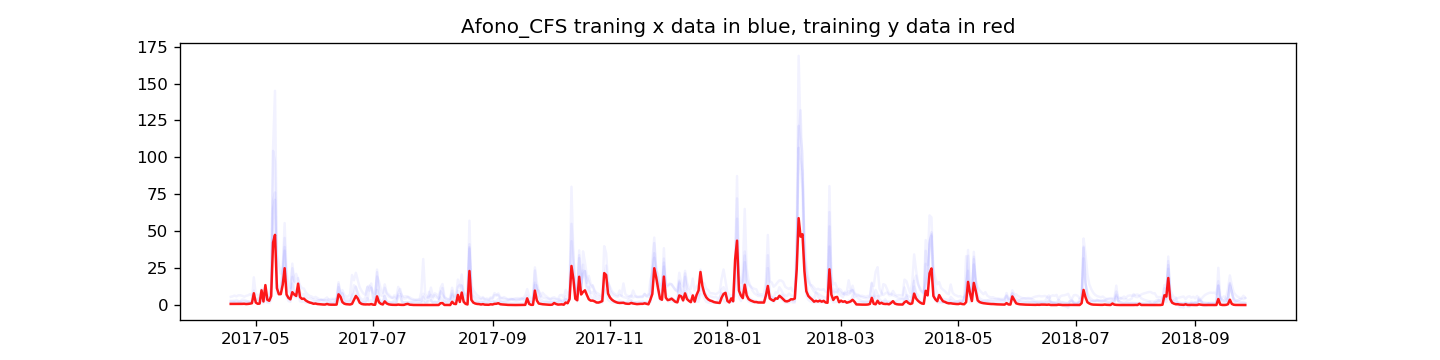

<IPython.core.display.Javascript object>


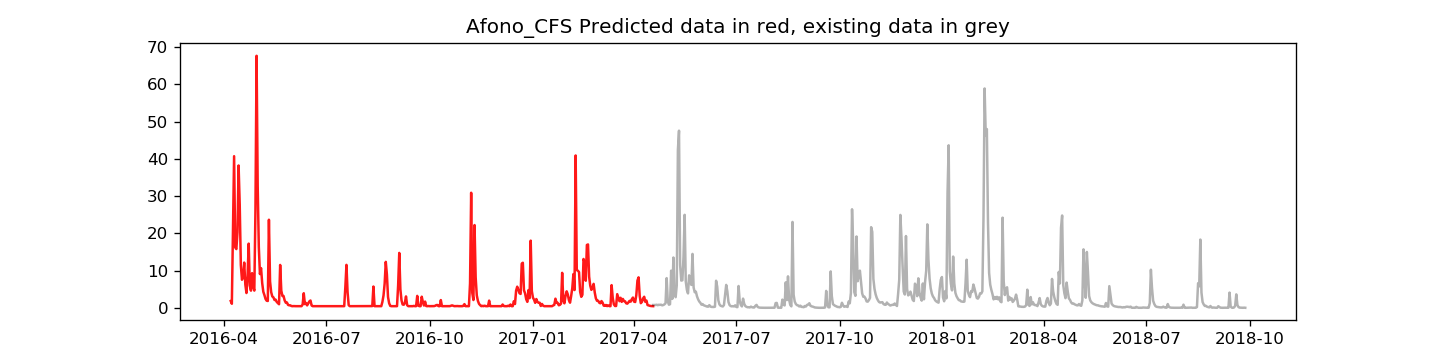

gap filling for station Malota_CFS
Training with stations Index(['Vaipito_CFS', 'Fagaalu_CFS', 'Leone_CFS'], dtype='object')


<IPython.core.display.Javascript object>


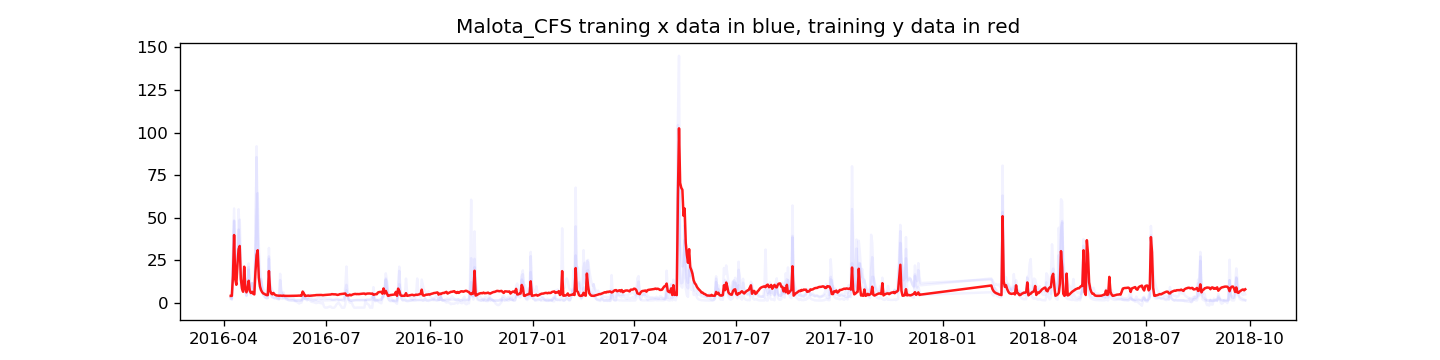

<IPython.core.display.Javascript object>


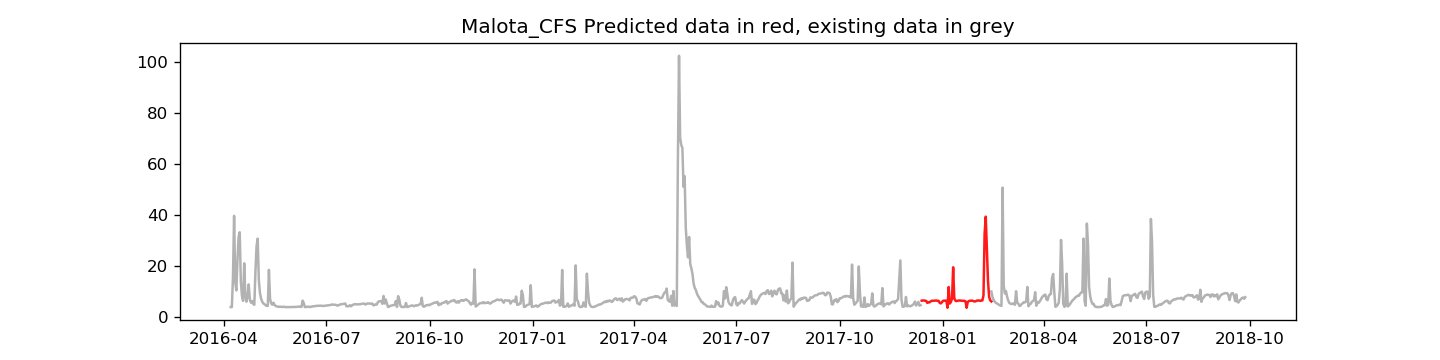

gap filling for station Fagaitua_CFS
Training with stations Index(['Leone_CFS', 'Vaipito_CFS', 'Fagasa_CFS'], dtype='object')


<IPython.core.display.Javascript object>


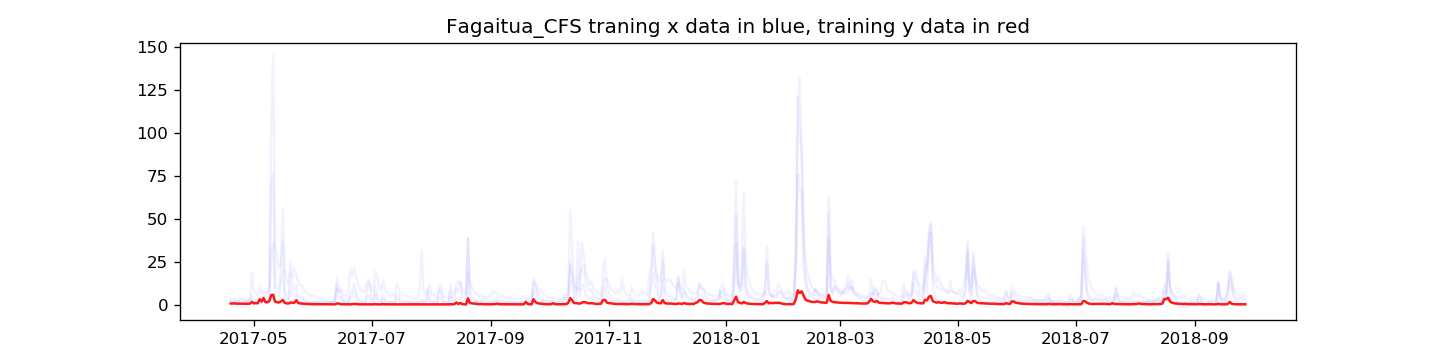

<IPython.core.display.Javascript object>


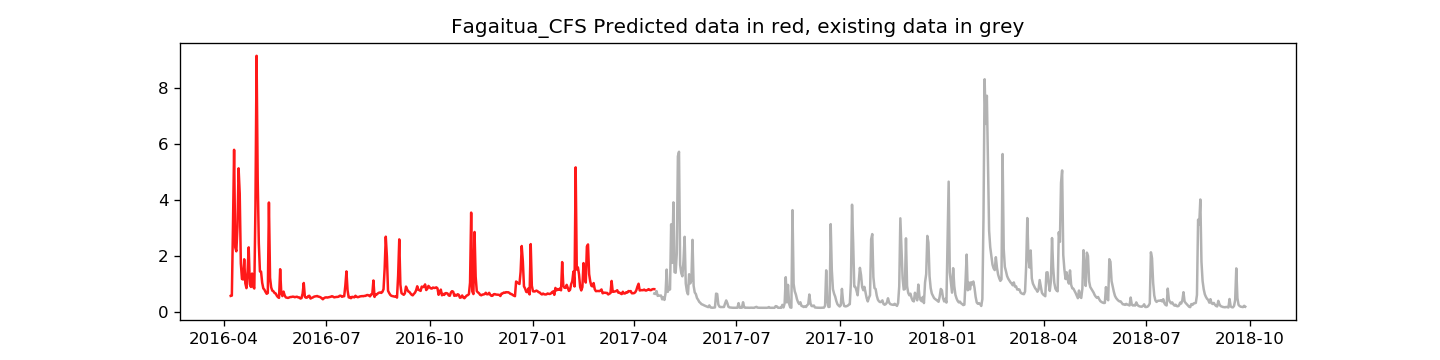

In [46]:
for i in broken_sets:

# Craete training data for the column of interest
    # find the 3-4 stations that have the highest correlation with the station of interest (i)
    sortomogo = corr[i].sort_values()
    del sortomogo[i]                              # remove the one station that is being gappped, all others are used for training
    trainlist = list(sortomogo[-4:].index)        # top 4 stations               
        
    local_data_pre_perfect = data_clipped[trainlist]             # get the actual data for the stations to be used for training
    trainlist = local_data_pre_perfect.dropna(axis=1).columns    # if any of the training stations for training are missing any rows, cut them out entirely
    local_data_perfect = data_clipped[[i]+list(trainlist)]             # Now =, with incomplete training stations cut out, make a frame of these satations plus the gapped staion
    local_data_perfect = local_data_perfect.dropna(axis=0)       # drop any rows (days) with Nan values in any of the stations (dont train where there are gaps)
    
    print("gap filling for station {}".format(i));  print("Training with stations {}".format(trainlist))

    X_train = local_data_perfect[trainlist].values          
    y_train = local_data_perfect[i].values     

    #scale values appropriately
    scaler = StandardScaler().fit(X_train)   # Define the scaler 
    X_train = scaler.transform(X_train)      # Scale the train set

    fig, ax = plt.subplots( figsize=(12, 3) )
    plt.plot(local_data_perfect.index, local_data_perfect[trainlist].values, color='blue', alpha = .05)    # show the nonscaled y training data
    plt.plot(local_data_perfect.index, y_train, color='red', alpha = .9)     # show the unscaled y training data  (with the gap)
    plt.title("{} traning x data in blue, training y data in red".format(i))
    
# DEEP netework go!            
    model = Sequential()
    model.add(Dense(48, activation='relu', input_shape=(len(trainlist),)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='relu'))
    #model.summary()

    # train the network using data from the one station
    model.compile(optimizer='Nadam', loss='mse', metrics=['mse'])
    #model.compile(loss='mean_squared_error',  optimizer='Nadam',  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=10, verbose=0)
    
## Now gap filling time: 
    # First: all of this is to go through each dataset and identify the start and the end of each gap. 

    a = data_clipped[i].values  # Extract out relevant column from dataframe as array
    m = np.concatenate(( [True], np.isnan(a), [True] ))  # Mask
    ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits

    gapstarts_L = []; gapends_L = []
    # this is if the series started late, i.e. the first gap is at the beginning
    if ss[0][0] != 0:     
        gapstart = 0
        gapstarts_L.append(gapstart)
        for m in ss:
            gapstart2 = m[1]
            gapstarts_L.append(gapstart2)
            gapends_L.append(m[0])
        del gapstarts_L[-1]                       # the end number is not the start of a new gap so delete this 

    # this is if the series starst at the beginning of the data period, first gap is in the middle 
    for m in ss:
        gapstarts_L.append(m[1])
        gapends_L.append(m[0])
    del gapstarts_L[-1]
    del gapends_L[0]

    gapstarts_Dates = []; gapends_Dates = []
    for h in gapstarts_L:
        date5 = data_clipped.index[h]
        gapstarts_Dates.append(date5)   # this is a list of the starting date of all gaps
    for h in gapends_L:
        date5 = data_clipped.index[h]
        gapends_Dates.append(date5)     # this is a list of all the ending dates of the gaps

## Now that gaps are identified, loop over each gap and fill using the trained network
    for idx, g in enumerate(gapstarts_Dates):
    
    # Prediction of virtual gaps GO!
        Predict_Start = g               # Start of the validatiaon data period, = end of training data 
        Predict_End = gapends_Dates[idx]                      # end of the validation data period (always the end of data all)

        X_predict_known = data_clipped.loc[Predict_Start:Predict_End, trainlist].values 
        
        #scale values appropriately
        scaler = StandardScaler().fit(X_predict_known)   # Define the scaler 
        X_predict_known = scaler.transform(X_predict_known) # Scale the train set

        y_predict_unknown = model.predict(X_predict_known)             # the network generated data for the gap   
        y_predict_unknown = y_predict_unknown.reshape([np.shape(y_predict_unknown)[0]]).tolist()  

        # plot
        fig, ax = plt.subplots( figsize=(12, 3) )
        plt.plot(data_clipped.loc[Predict_Start:Predict_End].index, y_predict_unknown, color='red', alpha = .9)     # show the unscaled y training data  (with the gap)
        plt.plot(data_clipped.index, data_clipped[i], color='k', alpha = .3)               # show the actual y data without the gap
        plt.title("{} Predicted data in red, existing data in grey".format(i))


# now actually fill in the missing data on the data dataframe 
        sneaky_data["{}_filled".format(i)] = sneaky_data[i]         # note that sneaky_data was defined in above cell, this makes a new column
        sneaky_data["{}_filled".format(i)].loc[Predict_Start:Predict_End] = y_predict_unknown # this fills it with the magic data

<IPython.core.display.Javascript object>


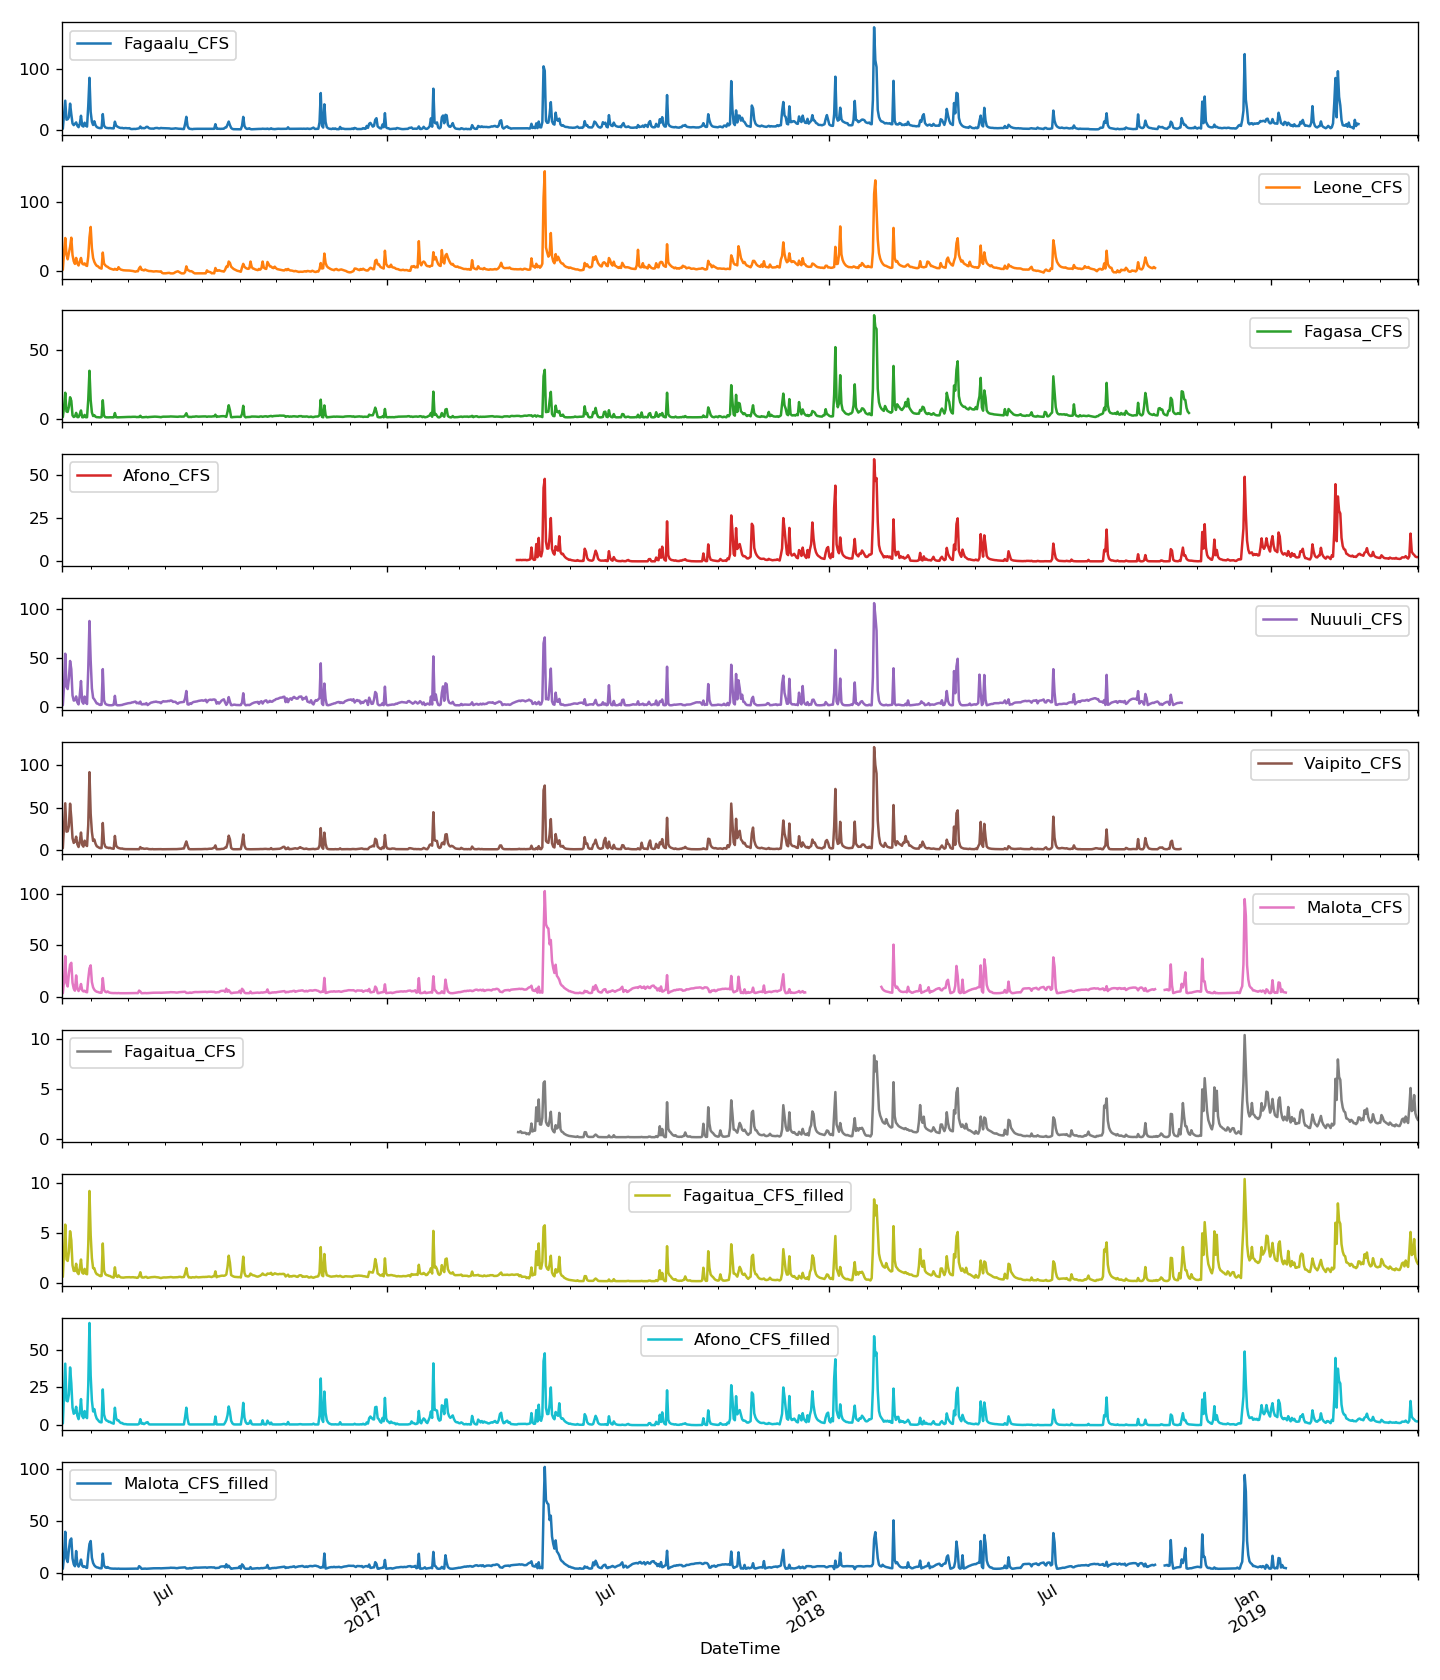

In [50]:
# plot results
sneaky_data.plot(subplots=True, figsize=(12, 14))
plt.tight_layout()
plt.legend(loc='best')

In [110]:
concept: 
    
    for training: find the 3 stations with the highest correlations use only these in train list. 
        run a not null on the dataframe of these 4 stations and use that to train with the station of interest. 
        
        then for gaps
        
        Id the gaps with the SS method
        loop over each gap in each column
        Id start nad end of each gap

'Malota_CFS'

# Junk

In [ ]:
# just blowing holes to test

a = data_clipped.index[700]
b = data_clipped.index[725]

c= data_clipped.index[800]
d= data_clipped.index[25]

data_poo = data_clipped.copy()

data_poo.loc[a:b]  = np.nan
data_poo.loc[c:d]  = np.nan

# plot results
data_poo.plot(subplots=True, figsize=(12, 8))
plt.tight_layout()
plt.legend(loc='best')





## all of this is just to loop over each dataset and identify the start and the end of each gap. 

a = data_poo['Malota_CFS'].values  # Extract out relevant column from dataframe as array
m = np.concatenate(( [True], np.isnan(a), [True] ))  # Mask
ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits

gapstarts_L = []; gapends_L = []
# this is if the series started late, i.e. the first gap is at the beginning
if ss[0][0] != 0:     
    gapstart = 0
    gapstarts_L.append(gapstart)
    for m in ss:
        gapstart2 = m[1]
        gapstarts_L.append(gapstart2)
        gapends_L.append(m[0])
    del gapstarts_L[-1]                       # the end number is not the start of a new gap so delete this 

# this is if the series starst at the beginning of the data period, first gap is in the middle 
for m in ss:
    gapstarts_L.append(m[1])
    gapends_L.append(m[0])
del gapstarts_L[-1]
del gapends_L[0]

gapstarts_Dates = []; gapends_Dates = []
for h in gapstarts_L:
    date5 = data_poo.index[h]
    gapstarts_Dates.append(date5)   # this is a list of the starting date of all gaps
for h in gapends_L:
    date5 = data_poo.index[h]
    gapends_Dates.append(date5)     # this is a list of all the ending dates of the gaps
    
    